# Assignment2 - Convolutional Neural Networks(CNN)

Convolutional neural network(CNN) is a feed-forward neural network that
is generally used to analyze visual images by processing data with grid-like topology. It’s also known as a ConvNet. A convolutional neural network is used to detect and classify objects in an image. The main objective of this assignment is to apply convnet to images, evaluating the model performance using pre trained networks.

“Deep learning for computer vision,” convents can be used 
successfully to classify images. Specifically, consider the Cats & Dogs example. There were two 
broad approaches to classifying Cats & Dogs using convnets: Training a network from scratch, 
versus using a pretrained convnet. While small datasets can lead to overfitting, thus making 
training a network for prediction more difficult, you also saw several techniques to reduce 
overfitting, and these include data augmentation and regularization.  

### Downloading the data
Here we download an API token from a Kaggle personal account.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maditatijayasri","key":"5c061c264aa1b75fa4bd30dd9b82cdef"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:03<00:00, 242MB/s]
100% 812M/812M [00:03<00:00, 225MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

## Q1. Training a convnet from scratch (1000 Samples)
Here We are going to develop a convolutional neural network from scratch.Now that the dataset is loaded, we can create subsets of it for our training, validation, and test data. Here, we use 1000 images for the training set, 500 for the validation set, and 500 for the test set.

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index): 
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
                            

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)



### Model building with training size of 1000 samples (Unregularised)

A convolution neural network has multiple hidden layers that help in extracting information from an image. The four important layers in CNN are:

1.   Convolution layer
2.   ReLU layer
3.   Pooling layer
4.   Fully connected layer

Since the input of this network is images(3D tensor), First we need to reshape the tensor.

Then, we use a series of convolution with a window size of 3x3(kernel_size) and maxpooling with a 2x2 window(pool_size).

The main objective of this assignment is Image classification, therefore as a final layer we use a dense layer that give us the probability that the output is classified as a "cat" or as a "dog". It has one output node, either "cat" or "dog". In order to feed the dense layer, we first need a layer that flatten the 3D shape in 1D.

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

From the model summary we can see that there are 991,000 parameters to optimize. 

Let us start with training the model on the training set.

**Configuring the model for training**

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Data preprocessing**

As we already know that, data should be formatted into tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

1.Read the picture files.

2.Decode the JPEG content to RBG grids of pixels.

3.Convert these into floating point tensors.

4.Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

But thankfully keras does it all.

**Using `image_dataset_from_directory` to read images**

This following chunk of code converts images to tensors in their specific folders of training,validation and test

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Fitting the model using a `Dataset`**

Let us now fit the model with the training set.Here We use "callbacks" because it will automatically store a file containing the weights generating from the best epoch so that we dont need to retrain the model.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 19s 125ms/step - loss: 0.7858 - accuracy: 0.5085 - val_loss: 0.7481 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 8s 114ms/step - loss: 0.6944 - accuracy: 0.5470 - val_loss: 0.6882 - val_accuracy: 0.5370
Epoch 3/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6769 - accuracy: 0.5780 - val_loss: 0.6758 - val_accuracy: 0.5810
Epoch 4/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6619 - accuracy: 0.6360 - val_loss: 0.6925 - val_accuracy: 0.5850
Epoch 5/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6180 - accuracy: 0.6605 - val_loss: 0.6284 - val_accuracy: 0.6620
Epoch 6/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5760 - accuracy: 0.6990 - val_loss: 0.5909 - val_accuracy: 0.7070
Epoch 7/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5393 - accuracy: 0.7325 - val_loss: 0.8740 - val_accuracy: 0.5850
Epoch

**Displaying curves of loss and accuracy during training**

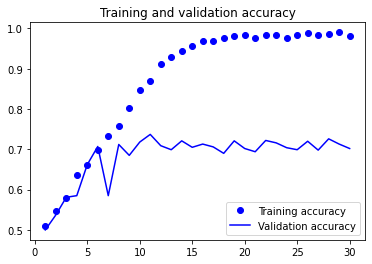

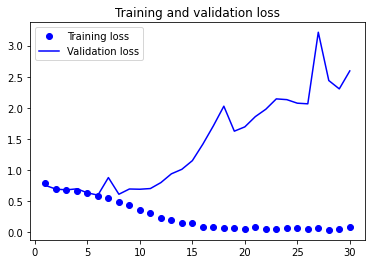

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

The validation and test accuracy of the model tends to be very low which is 70%. In order to improve performance, we will train our model using few techniques
a) Data Augmentation
b) Drop out Method
c) Data Augmentation and drop out method 

After model evaluation with these three techniques, i will choose the technique which improves the performance of the model going forward.

### Techniques to improve performance  

### a) Data Augmentation

**Defining a new convnet that includes Data Augmentation**

**Define a data augmentation stage to add to an image model**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Defining a new convnet that includes image augmentation**

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
     callbacks=callbacks)

**Evaluating the test dataset**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 47ms/step - loss: 0.4012 - accuracy: 0.8590
Test accuracy: 0.859


### b) Dropout method

**Defining a new convnet that includes dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularised convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 114ms/step - loss: 0.7050 - accuracy: 0.4985 - val_loss: 0.6912 - val_accuracy: 0.5040
Epoch 2/30
63/63 [==============================] - 7s 111ms/step - loss: 0.7000 - accuracy: 0.5380 - val_loss: 0.7065 - val_accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6820 - accuracy: 0.5955 - val_loss: 0.6703 - val_accuracy: 0.5700
Epoch 4/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6437 - accuracy: 0.6320 - val_loss: 0.6444 - val_accuracy: 0.6560
Epoch 5/30
63/63 [==============================] - 11s 171ms/step - loss: 0.6140 - accuracy: 0.6750 - val_loss: 0.6303 - val_accuracy: 0.6620
Epoch 6/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5889 - accuracy: 0.6915 - val_loss: 0.5770 - val_accuracy: 0.6910
Epoch 7/30
63/63 [==============================] - 7s 111ms/step - loss: 0.5455 - accuracy: 0.7335 - val_loss: 0.6303 - val_accuracy: 0.6880
Epoch

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.5442 - accuracy: 0.7470
Test accuracy: 0.747


### c) Using Image Augmentation and Dropout method

**Define a data augmentation stage to add to an image model**




In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Defining a new convnet that includes image augmentation and dropout**

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 120ms/step - loss: 0.7097 - accuracy: 0.5170 - val_loss: 0.6916 - val_accuracy: 0.5060
Epoch 2/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6962 - accuracy: 0.5245 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6980 - accuracy: 0.5440 - val_loss: 0.6726 - val_accuracy: 0.6000
Epoch 4/100
63/63 [==============================] - 8s 116ms/step - loss: 0.6809 - accuracy: 0.5890 - val_loss: 0.6673 - val_accuracy: 0.6120
Epoch 5/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6693 - accuracy: 0.6100 - val_loss: 0.6472 - val_accuracy: 0.6240
Epoch 6/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6548 - accuracy: 0.6300 - val_loss: 0.6474 - val_accuracy: 0.6250
Epoch 7/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6420 - accuracy: 0.6435 - val_loss: 0.6485 - val_accuracy: 0.6230

**Evaluating the model on the test set**

In [16]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 12s 56ms/step - loss: 0.4432 - accuracy: 0.8380
Test accuracy: 0.838


## Q2. Increasing Training sample size.(5000 samples)

Here I have increased the training samples to 5000 and evlaute the model performance and explain all the findings in the summary.

In [9]:
make_subset("train_3", start_index=1000, end_index=6000)

train_dataset3 = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)


Found 10000 files belonging to 2 classes.


### Model Building with Image Augmentation and drop out

**Defining a new convnet that includes image augmentation and dropout**

In [27]:


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularised convnet**

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset3,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
625/625 [==============================] - 54s 86ms/step - loss: 0.3940 - accuracy: 0.8253 - val_loss: 0.3318 - val_accuracy: 0.8680
Epoch 2/70
625/625 [==============================] - 54s 86ms/step - loss: 0.3236 - accuracy: 0.8598 - val_loss: 0.3676 - val_accuracy: 0.8480
Epoch 3/70
625/625 [==============================] - 54s 86ms/step - loss: 0.2715 - accuracy: 0.8852 - val_loss: 0.2361 - val_accuracy: 0.9020
Epoch 4/70
625/625 [==============================] - 54s 86ms/step - loss: 0.2258 - accuracy: 0.9063 - val_loss: 0.2504 - val_accuracy: 0.8980
Epoch 5/70
625/625 [==============================] - 54s 87ms/step - loss: 0.2091 - accuracy: 0.9164 - val_loss: 0.2476 - val_accuracy: 0.8970
Epoch 6/70
625/625 [==============================] - 54s 86ms/step - loss: 0.1845 - accuracy: 0.9287 - val_loss: 0.2268 - val_accuracy: 0.9140
Epoch 7/70
625/625 [==============================] - 54s 86ms/step - loss: 0.1702 - accuracy: 0.9345 - val_loss: 0.2592 - val_accuracy:

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.2135 - accuracy: 0.9240
Test accuracy: 0.924


## Q3. Increasing Training samples further more.(10000 Samples)
As per the instructions given, i increased the training samples further more that is from 5000 to 10000 samples and evaluate the model performance and will include the observations in the summary.

In [8]:

#import shutil
#shutil.rmtree('/content/cats_vs_dogs_small/train_2')

make_subset("train_2", start_index=1000, end_index=11000)

train_dataset2 = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)



Found 20000 files belonging to 2 classes.


### Model Building with Image augmentation and dropout

**Defining a new convnet that includes image augmentation and dropout**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])



In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_test3.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset3,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 41s 92ms/step - loss: 0.6855 - accuracy: 0.5772 - val_loss: 0.7624 - val_accuracy: 0.5570
Epoch 2/30
313/313 [==============================] - 28s 89ms/step - loss: 0.5817 - accuracy: 0.6971 - val_loss: 0.5424 - val_accuracy: 0.7420
Epoch 3/30
313/313 [==============================] - 28s 90ms/step - loss: 0.4961 - accuracy: 0.7622 - val_loss: 0.4715 - val_accuracy: 0.7790
Epoch 4/30
313/313 [==============================] - 28s 89ms/step - loss: 0.4233 - accuracy: 0.8104 - val_loss: 0.4062 - val_accuracy: 0.8190
Epoch 5/30
313/313 [==============================] - 28s 89ms/step - loss: 0.3728 - accuracy: 0.8400 - val_loss: 0.4949 - val_accuracy: 0.7780
Epoch 6/30
313/313 [==============================] - 28s 90ms/step - loss: 0.3096 - accuracy: 0.8701 - val_loss: 0.3798 - val_accuracy: 0.8270
Epoch 7/30
313/313 [==============================] - 29s 90ms/step - loss: 0.2515 - accuracy: 0.8935 - val_loss: 0.4198 - val_accuracy:

In [13]:
test_model = keras.models.load_model(
    "convnet_from_scratch_test3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 52ms/step - loss: 0.3673 - accuracy: 0.8350
Test accuracy: 0.835


In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularised convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset2,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
313/313 [==============================] - 29s 88ms/step - loss: 0.6959 - accuracy: 0.5804 - val_loss: 0.6150 - val_accuracy: 0.6740
Epoch 2/70
313/313 [==============================] - 28s 88ms/step - loss: 0.5858 - accuracy: 0.6979 - val_loss: 0.5549 - val_accuracy: 0.7170
Epoch 3/70
313/313 [==============================] - 28s 89ms/step - loss: 0.5042 - accuracy: 0.7627 - val_loss: 0.4489 - val_accuracy: 0.8040
Epoch 4/70
313/313 [==============================] - 28s 88ms/step - loss: 0.4375 - accuracy: 0.7959 - val_loss: 0.5118 - val_accuracy: 0.7930
Epoch 5/70
313/313 [==============================] - 28s 88ms/step - loss: 0.3850 - accuracy: 0.8274 - val_loss: 0.4813 - val_accuracy: 0.7920
Epoch 6/70
313/313 [==============================] - 28s 88ms/step - loss: 0.3392 - accuracy: 0.8556 - val_loss: 0.3881 - val_accuracy: 0.8300
Epoch 7/70
313/313 [==============================] - 28s 88ms/step - loss: 0.2955 - accuracy: 0.8765 - val_loss: 0.4577 - val_accuracy:

**Evaluating the test data**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.3784 - accuracy: 0.8440
Test accuracy: 0.844


## Q4. Leveraging a pretrained model - Fine Tuning

Here we will fine tune the pretrained model and evaluate the model performance on the models which were built above using different training sample sizes and include my findings in summary.

### Pre-Trained Model - 1000 Training samples


**Instantiating and freezing the VGG16 convolutional base**

In [17]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [18]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Fine-tuning a pretrained model**

In [19]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)


**Freezing all layers until the fourth from the last**

In [20]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base**

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


In [22]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 30s 393ms/step - loss: 4.1226 - accuracy: 0.7470 - val_loss: 0.8636 - val_accuracy: 0.9020
Epoch 2/30
63/63 [==============================] - 23s 355ms/step - loss: 1.1697 - accuracy: 0.8610 - val_loss: 0.5299 - val_accuracy: 0.9310
Epoch 3/30
63/63 [==============================] - 23s 360ms/step - loss: 0.6559 - accuracy: 0.9035 - val_loss: 0.3201 - val_accuracy: 0.9660
Epoch 4/30
63/63 [==============================] - 23s 357ms/step - loss: 0.4311 - accuracy: 0.9260 - val_loss: 0.2289 - val_accuracy: 0.9630
Epoch 5/30
63/63 [==============================] - 23s 358ms/step - loss: 0.3696 - accuracy: 0.9305 - val_loss: 0.1934 - val_accuracy: 0.9580
Epoch 6/30
63/63 [==============================] - 23s 356ms/step - loss: 0.2379 - accuracy: 0.9345 - val_loss: 0.1621 - val_accuracy: 0.9670
Epoch 7/30
63/63 [==============================] - 23s 357ms/step - loss: 0.1726 - accuracy: 0.9550 - val_loss: 0.1372 - val_accuracy: 0.9740

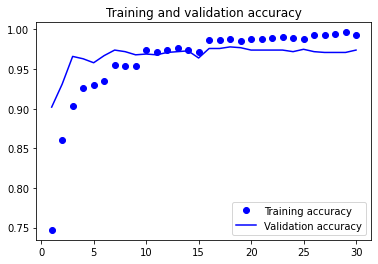

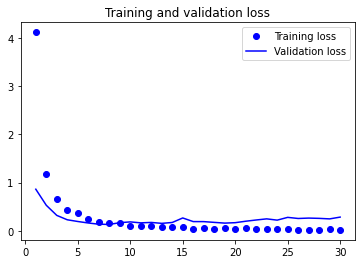

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 207ms/step - loss: 0.1719 - accuracy: 0.9730
Test accuracy: 0.973


### Pre-Trained Model with 5000 Training samples


**Instantiating and freezing the VGG16 convolutional base**

In [31]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Fine tuning the pretrained model and freezing the layers**

In [32]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base**

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset3,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 164s 258ms/step - loss: 0.2549 - accuracy: 0.8999 - val_loss: 0.1061 - val_accuracy: 0.9760
Epoch 2/10
625/625 [==============================] - 161s 257ms/step - loss: 0.1154 - accuracy: 0.9606 - val_loss: 0.1078 - val_accuracy: 0.9770
Epoch 3/10
625/625 [==============================] - 161s 257ms/step - loss: 0.1018 - accuracy: 0.9650 - val_loss: 0.1334 - val_accuracy: 0.9770
Epoch 4/10
625/625 [==============================] - 161s 257ms/step - loss: 0.0859 - accuracy: 0.9702 - val_loss: 0.1033 - val_accuracy: 0.9750
Epoch 5/10
625/625 [==============================] - 161s 257ms/step - loss: 0.0799 - accuracy: 0.9743 - val_loss: 0.1112 - val_accuracy: 0.9820
Epoch 6/10
625/625 [==============================] - 161s 256ms/step - loss: 0.0786 - accuracy: 0.9739 - val_loss: 0.1157 - val_accuracy: 0.9800
Epoch 7/10
625/625 [==============================] - 161s 257ms/step - loss: 0.0806 - accuracy: 0.9748 - val_loss: 0.1141 -

In [35]:
model = keras.models.load_model("fine_tuning3.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 206ms/step - loss: 0.0496 - accuracy: 0.9810
Test accuracy: 0.981


### Pre-Trained Model with 10000 samples

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Fine tuning the pretrained model and freezing the layers**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
313/313 [==============================] - 86s 268ms/step - loss: 1.3573 - accuracy: 0.8671 - val_loss: 0.1511 - val_accuracy: 0.9670
Epoch 2/30
313/313 [==============================] - 85s 268ms/step - loss: 0.2355 - accuracy: 0.9370 - val_loss: 0.1410 - val_accuracy: 0.9690
Epoch 3/30
313/313 [==============================] - 85s 269ms/step - loss: 0.1505 - accuracy: 0.9527 - val_loss: 0.1389 - val_accuracy: 0.9700
Epoch 4/30
313/313 [==============================] - 84s 268ms/step - loss: 0.1184 - accuracy: 0.9592 - val_loss: 0.1501 - val_accuracy: 0.9740
Epoch 5/30
313/313 [==============================] - 85s 270ms/step - loss: 0.1089 - accuracy: 0.9635 - val_loss: 0.1342 - val_accuracy: 0.9750
Epoch 6/30
313/313 [==============================] - 84s 269ms/step - loss: 0.0881 - accuracy: 0.9700 - val_loss: 0.1372 - val_accuracy: 0.9780
Epoch 7/30
313/313 [==============================] - 85s 269ms/step - loss: 0.0800 - accuracy: 0.9737 - val_loss: 0.1339 - val_ac

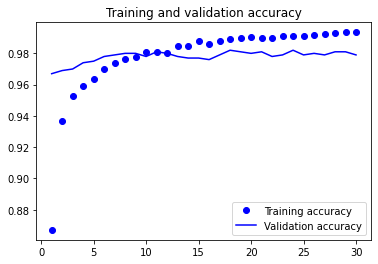

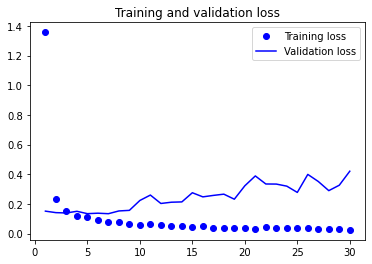

In [ ]:

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning2.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 208ms/step - loss: 0.0893 - accuracy: 0.9780
Test accuracy: 0.978


## Summary:

### **Q1. Training a convnet from scratch (1000 Samples)**

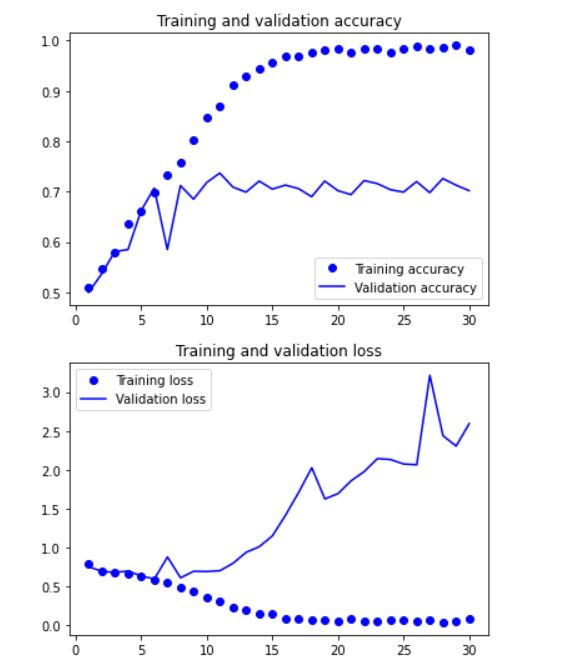

**Observations:**

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples, overfitting is going to be our main concern. we already know that there are multiple techniques that can help reduce overfitting, such as dropout, weight decay (L2 regularization) and data augmentation.

**Data Augmentation:**

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.  Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.




As per the instructions given in the assignment, Initially, I have built a baseline model which is (unregularised model) with 1000 training samples and 500 samples for each validation and test datasets for each categorry of dog and cat.


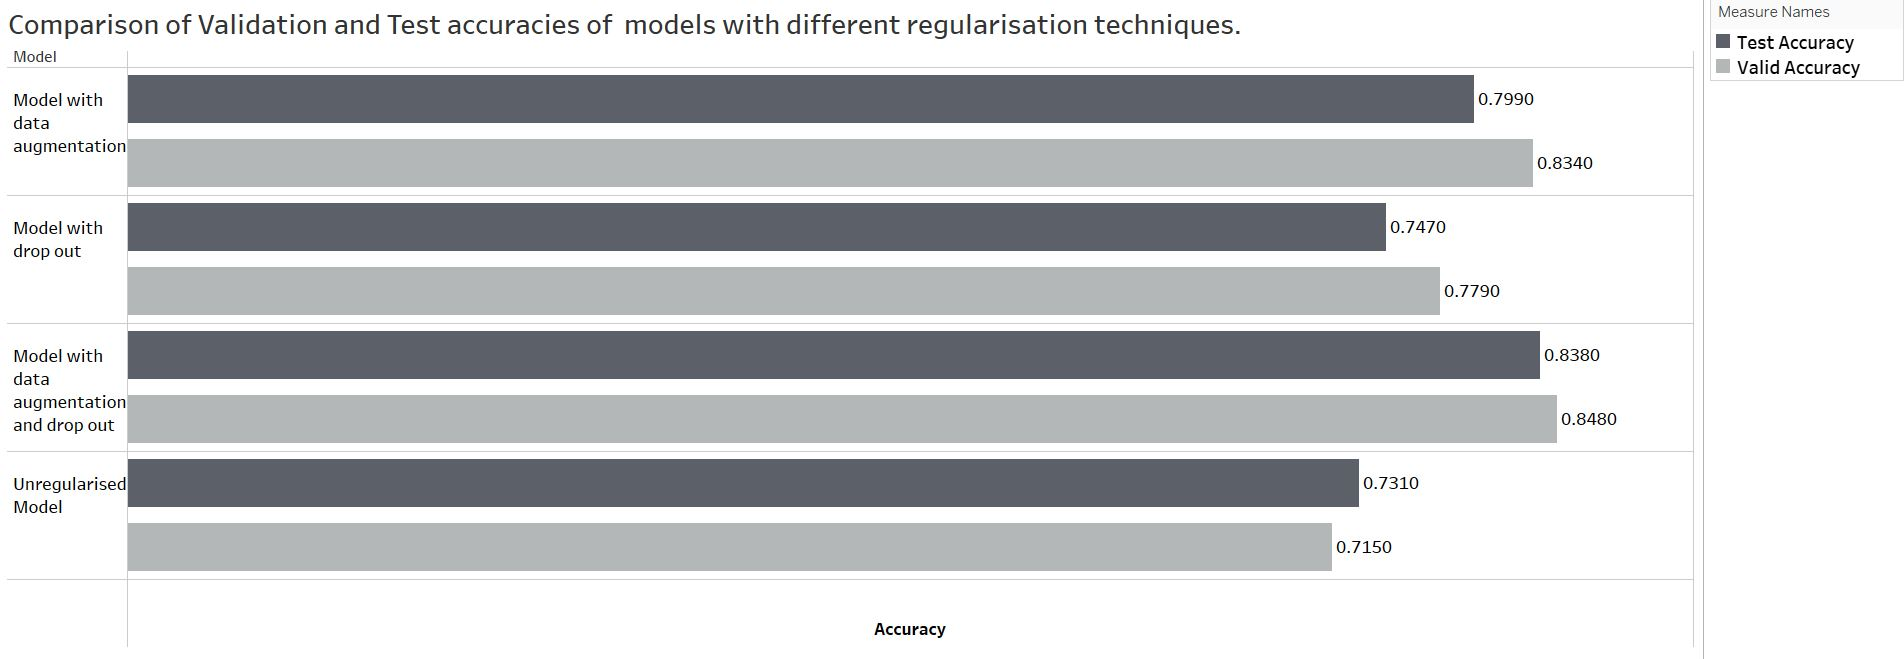


I have used three techniques to improve the performance of the model and evaluated all those three on test dataset on 100 epochs.

a) Drop out Method

b) Data Augmentation

c) Data Augmentation and drop out method.

**Observations:**

From the above chart, we can see the performance metrics of the models with three performance improvement techniques along with the unregularised model and can find that model with both data aumentation and drop out technique is performing well.

So going forward I would be using the data augmentation and drop out  method to regularise the model.

### **Q2&Q3. Increasing the training samples(5000) and further more(10000)**

As mentioned above that I have used 1000 training samples to create a baseline model and then regularised it . Now lets increase the training samples to 5000 further more to 10000 and check the performance of the models.

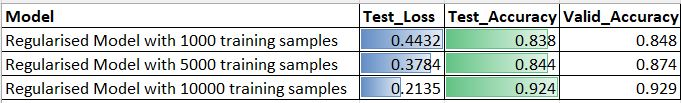

**Observations:**

As it is evident that Test loss decreases as the training sample size increases and test accuracy increases from (83% to 92.4%) which is better improvement.

we can conclude that the model peformance increases as the training sample size increases. 

Below is the chart that describes the comparison of test and validation accuracies for the different training samples size.

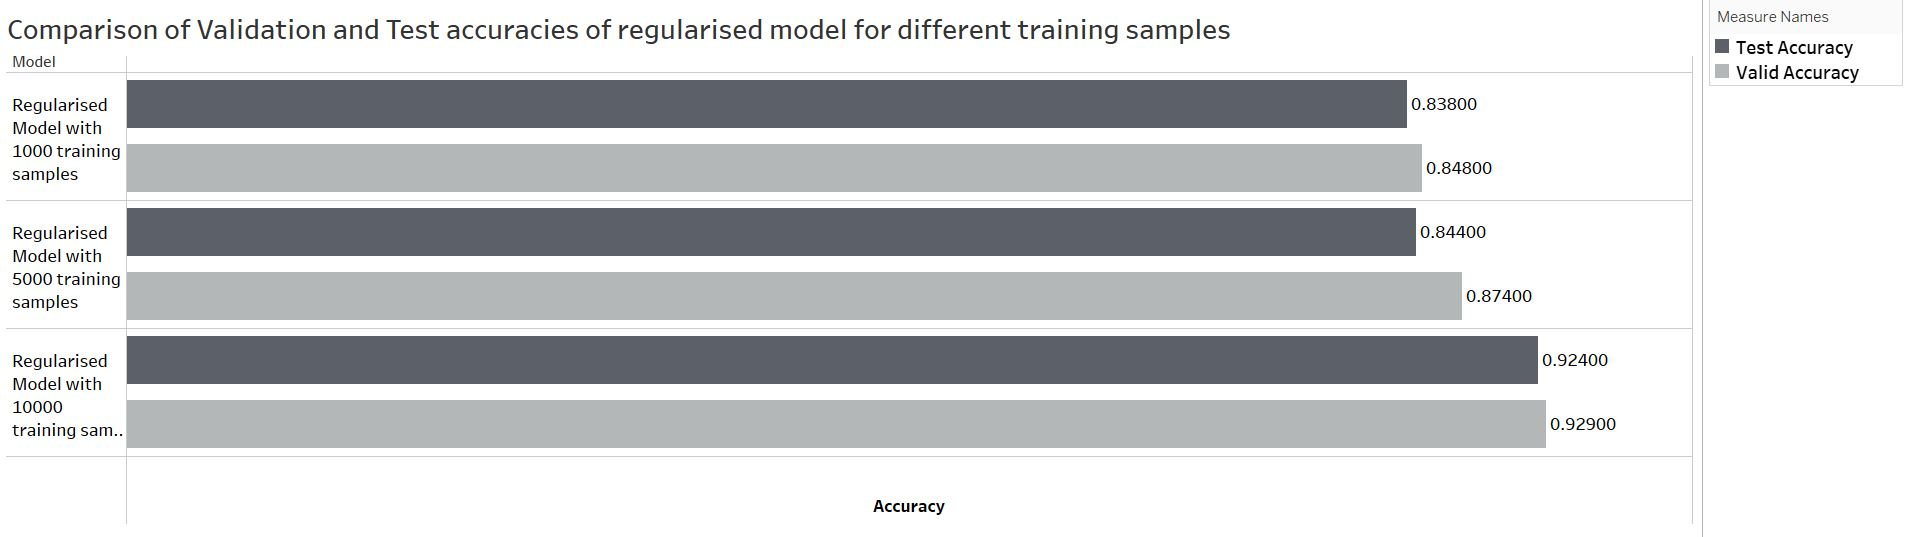

### **Q4. Use a Pre-Trained Convnet**

As a next step to further improve our accuracy on this problem, we will have to leverage a pre-trained model.

**Pre-Trained Convnet:**

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

**VGG16 Architecture:**

Here I chose to use VGG16 Architecture, which is a simple and widely used convnet architecture for ImageNet to further improve the performance of the model.

There are two ways to leverage a pre-trained network: 

**1.Feature extraction**

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

**2.Fine-Tuning:**

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. 

This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

Here I tried the evaluate the model performance using fine-tuning the pretrained model for different training sample sizes.


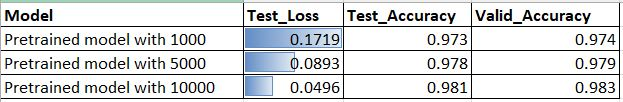

**Observations:**

We can see that accuracy of both validation and test tends to increase slightly as the training sample size increases.Considering test loss,we can see a better improvement as the sample size increases.


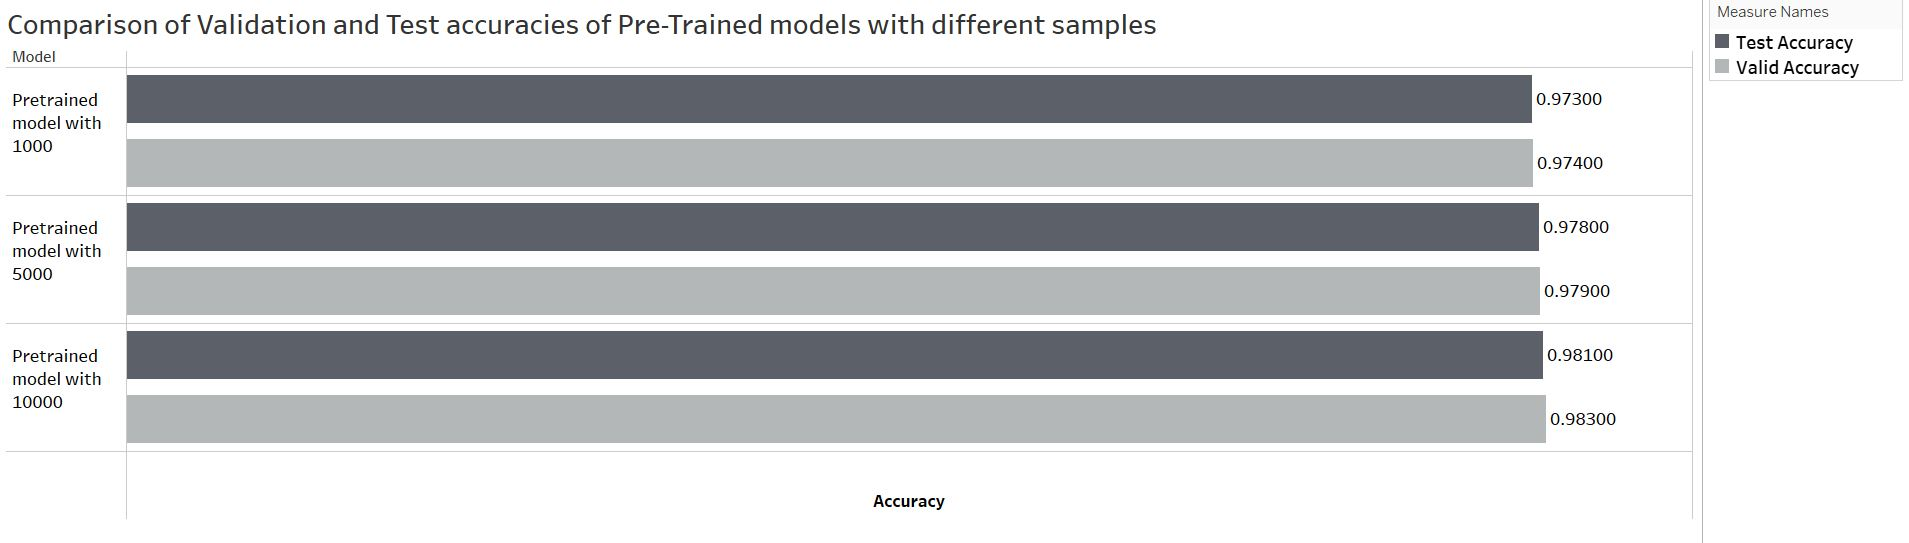

### **Conclusion:**

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* As the training sample size increases, the model performance also increases.
* Fine-tuning the pre-trained model, we can push performance of the model bit further.


**References:**

https://github.com/fchollet/deep-learning-with-python-notebooks.git